In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import gseapy as gp
import statsmodels.api as sm
from adjustText import adjust_text

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Set file paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
DF_HOM = pd.read_csv(DATA_PATH+'/gene_annotation/mouse_human_homologs.txt', sep='\t')
DIC_MAP_H2M = {x:y for x,y in zip(DF_HOM['HUMAN_GENE_SYM'], DF_HOM['MOUSE_GENE_SYM'])}
DIC_MAP_M2H = {x:y for x,y in zip(DF_HOM['MOUSE_GENE_SYM'], DF_HOM['HUMAN_GENE_SYM'])}
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_contrast.rv1'

# Set data info
DS_LIST = ['tms_facs']
DIC_INFO = {}
DIC_INFO['tms_facs'] = {'species': 'mmusculus', 'dname': 'TMS FACS'}
DIC_INFO['tms_droplet'] = {'species': 'mmusculus', 'dname': 'TMS droplet'}
DIC_INFO['ts_facs'] = {'species': 'hsapiens', 'dname': 'TS FACS'}
DIC_INFO['canogamez'] = {'species': 'hsapiens', 'dname': 'Cano-Gamez & Soskic et al.'}
DIC_INFO['nathan'] = {'species': 'hsapiens', 'dname': 'Nathan et al.'}

# Set score file
DIC_SCORE_PATH = {'tms_facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
                  'tms_facs_uniform': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_uniform',
#                   'tms_facs.tsig': DATA_PATH+'/score_file/score.tms_facs_with_cov.tcell_sig',
                 }

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['immune'] = [
    'PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017', 'PASS_Rheumatoid_Arthritis', 
    'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
    'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 
    'UKB_460K.disease_RESPIRATORY_ENT'
]
DIC_TRAIT_LIST['brain'] = [
    'PASS_BIP_Mullins2021', 'PASS_MDD_Howard2019', 'PASS_Schizophrenia_Pardinas2018', 
    'UKB_460K.mental_NEUROTICISM', 'UKB_460K.cov_EDU_COLLEGE', 'UKB_460K.body_BMIz', 'UKB_460K.cov_SMOKING_STATUS'
    
]
DIC_TRAIT_LIST['metabolic'] = [
    'UKB_460K.biochemistry_Triglycerides', 'UKB_460K.biochemistry_HDLcholesterol',
    'UKB_460K.biochemistry_LDLdirect', 'UKB_460K.biochemistry_Cholesterol', 
    'UKB_460K.biochemistry_Testosterone_Male', 'UKB_460K.biochemistry_AlanineAminotransferase',
    'UKB_460K.biochemistry_AlkalinePhosphatase', 'UKB_460K.biochemistry_SHBG', 
    'UKB_460K.biochemistry_TotalBilirubin'
]
DIC_TRAIT_LIST['tms_facs'] = list(DF_TRAIT_INFO['Trait_Identifier'])
DIC_TRAIT_LIST['tms_facs_uniform'] = list(DF_TRAIT_INFO['Trait_Identifier'])
# DIC_TRAIT_LIST['tms_facs'] = [
#     'PASS_IBD_deLange2017', 'PASS_CD_deLange2017','PASS_UC_deLange2017', 'PASS_Rheumatoid_Arthritis', 
#     'PASS_Multiple_sclerosis', 'UKB_460K.disease_AID_ALL', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP',
#     'UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED', 'UKB_460K.disease_ASTHMA_DIAGNOSED', 
#     'UKB_460K.disease_RESPIRATORY_ENT', 'UKB_460K.body_HEIGHTz'
# ]
DIC_TRAIT_LIST['tms_facs.tsig'] = [
    'naive_cd4', 'memory_cd4', 'effector_cd4', 'naive_cd8', 'memory_cd8', 'effector_cd8'
]

# Add T cell signatures to DF_TRAIT_INFO
temp_dic = {
    'naive_cd4':'Naive CD4', 'memory_cd4':'Memory CD4', 'effector_cd4':'Effector CD4',
    'naive_cd8':'Naive CD8', 'memory_cd8':'Memory CD8', 'effector_cd8':'Effector CD8'
}
for trait in temp_dic:
    DF_TRAIT_INFO.loc[trait, ['Trait_Identifier', 'Code']] = [trait, temp_dic[trait]]

### Load data 

In [3]:
# Load single-cell data 
dic_data_raw = {}
dic_data_raw['tms_facs'] = scdrs.data_loader.load_tms_ct(DATA_PATH, data_name='facs')

dic_data_proc = {}
dic_data_proc['tms_facs.tcell'] = read_h5ad(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/tms_proc/tcell.facs.annot.h5ad')
dic_data_proc['tms_facs.hep'] = read_h5ad(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/single_cell_data/tms_proc/hep.facs_annot.h5ad')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path) 

### Similarity across 74 traits:
1. Statistics: 
    - Gene set overlap 
    - Score correlation
2. Heatmap of traits from the same domain 

In [5]:
# Statistics
ds,score,score_ref = 'tms_facs','tms_facs','tms_facs_uniform'
trait_list = list(DF_GS.index)
trait_list_main = DIC_TRAIT_LIST['immune'] + DIC_TRAIT_LIST['brain'] + DIC_TRAIT_LIST['metabolic']
cate_list = list(DF_TRAIT_INFO.loc[trait_list, 'Category'].unique())

df_overlap = pd.DataFrame(index=trait_list, columns=trait_list, dtype=int)
for i in range(len(trait_list)):
    for j in range(i, len(trait_list)):
        trait_i = trait_list[i]
        trait_j = trait_list[j]
        gene_list_i = [x.split(':')[0] for x in DF_GS.loc[trait_i, 'GENESET'].split(',')]
        gene_list_j = [x.split(':')[0] for x in DF_GS.loc[trait_j, 'GENESET'].split(',')]
        df_overlap.loc[trait_i, trait_j] = len(set(gene_list_i) & set(gene_list_j))
        df_overlap.loc[trait_j, trait_i] = len(set(gene_list_i) & set(gene_list_j))
df_overlap = df_overlap.astype(int)

df_corr = dic_score[score][['%s.norm_score'%x for x in trait_list]].corr()
df_corr.columns = [x.replace('.norm_score','') for x in df_corr.columns]
df_corr.index = [x.replace('.norm_score','') for x in df_corr.index]

df_corr_ref = dic_score[score_ref][['%s.norm_score'%x for x in trait_list]].corr()
df_corr_ref.columns = [x.replace('.norm_score','') for x in df_corr_ref.columns]
df_corr_ref.index = [x.replace('.norm_score','') for x in df_corr_ref.index]

# Create a masked version 
df_overlap_mask = df_overlap.copy()
df_corr_mask = df_corr.copy()
for cate in cate_list:
    trait_list_cate = [x for x in trait_list if DF_TRAIT_INFO.loc[x, 'Category']==cate]
    df_overlap_mask.loc[trait_list_cate, trait_list_cate] = np.nan
    df_corr_mask.loc[trait_list_cate, trait_list_cate] = np.nan

# DESCRIPTION_FILE = '/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted_2021/Description_070121.xlsx'
# DF_GENET_CORR = pd.read_excel(DESCRIPTION_FILE, sheet_name=2, index_col=0)
# df_genet_corr = DF_GENET_CORR.loc[trait_list, trait_list]

# Category-level summary 
def pairwise_mean_jn(df_data):
    n_sample = df_data.shape[0]
    v_jn = np.zeros(n_sample)
    for i_col,col in enumerate(df_data):
        temp_df = df_data.loc[df_data.index!=col, df_data.columns!=col]
        v_val = temp_df.values[np.tril_indices(temp_df.shape[0], k=-1)]
        v_jn[i_col] = np.nanmean(v_val)
    return v_jn.mean(),v_jn.std() * np.sqrt((n_sample-1)/n_sample)

# Results across 74 traits 
df_stats = pd.DataFrame(index = cate_list+['inter-domain'],
                        columns=['Number of traits', 'Overlap', 'Overlap SE', 'Corr', 'Corr SE'])
for cate in df_stats.index:
    if cate=='inter-domain':
        df_overlap_cate = df_overlap_mask
        df_corr_cate = df_corr_mask
    else:
        trait_list_cate = [x for x in trait_list if DF_TRAIT_INFO.loc[x, 'Category']==cate]
        df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
        df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
    
    overlap_mean,overlap_se = pairwise_mean_jn(df_overlap_cate)
    corr_mean,corr_se = pairwise_mean_jn(df_corr_cate)    
    df_stats.loc[cate] = [df_corr_cate.shape[0], overlap_mean,overlap_se,corr_mean,corr_se]
    
df_stats.index = [x.capitalize() for x in df_stats.index]
print(df_stats.to_latex(index=True, escape=False, column_format='|c|ccccc|'))

# Results across 26 main traits 
df_stats = pd.DataFrame(index = ['immune', 'brain', 'metabolic', 'inter-domain'], 
                       columns=['Number of traits', 'Overlap', 'Overlap SE', 'Corr', 'Corr SE'])
for cate in df_stats.index:
    if cate=='inter-domain':
        df_overlap_cate = df_overlap_mask
        df_corr_cate = df_corr_mask
    else:
        trait_list_cate = DIC_TRAIT_LIST[cate]
        df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
        df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
        
    overlap_mean,overlap_se = pairwise_mean_jn(df_overlap_cate)
    corr_mean,corr_se = pairwise_mean_jn(df_corr_cate)    
    df_stats.loc[cate] = [df_corr_cate.shape[0], overlap_mean,overlap_se,corr_mean,corr_se]
    
df_stats.index = [x.capitalize() for x in df_stats.index]
print(df_stats.to_latex(index=True, escape=False, column_format='|c|ccccc|'))

# Comparison between zscore and uniform weightsscores 
v_val = df_corr.values[np.tril_indices(df_corr.shape[0], k=-1)]
v_val_ref = df_corr_ref.values[np.tril_indices(df_corr_ref.shape[0], k=-1)]
print('Corr. of df_corr', np.corrcoef(v_val, v_val_ref)[0,1])

# Score correlation and power improvement
v_corr = np.zeros(len(trait_list))
v_sig_ratio = np.zeros(len(trait_list))
for i_trait,trait in enumerate(trait_list):
    v_corr[i_trait] = np.corrcoef(
        dic_score[score]['%s.norm_score'%trait], dic_score[score_ref]['%s.norm_score'%trait]
    )[0,1]
    v_sig_ratio[i_trait] = ((dic_score[score]['%s.fdr'%trait]<0.1).sum()+1) / \
        ((dic_score[score_ref]['%s.fdr'%trait]<0.1).sum()+1)
print('Median score corrlation', np.median(v_corr))
print('Median sig ratio', np.median(v_sig_ratio))

\begin{tabular}{|c|ccccc|}
\toprule
{} & Number of traits &  Overlap & Overlap SE &       Corr &     Corr SE \\
\midrule
Brain        &               21 &  154.476 &    3.75811 &   0.327712 &   0.0089121 \\
Heart        &                6 &    295.8 &    56.4939 &   0.407929 &   0.0509792 \\
Blood/immune &               21 &  167.029 &    3.01414 &   0.335623 &  0.00929093 \\
Metabolic    &               13 &  230.346 &    6.41445 &   0.270246 &  0.00882339 \\
Other        &               13 &  120.218 &    4.11649 &   0.182988 &   0.0170624 \\
Inter-domain &               74 &  105.728 &   0.460632 &  0.0614439 &  0.00120868 \\
\bottomrule
\end{tabular}

\begin{tabular}{|c|ccccc|}
\toprule
{} & Number of traits &  Overlap & Overlap SE &       Corr &     Corr SE \\
\midrule
Immune       &               10 &  230.733 &    10.0013 &   0.507497 &  0.00673854 \\
Brain        &                7 &  199.333 &    4.39307 &   0.439846 &   0.0119325 \\
Metabolic    &                9 &  275.389 

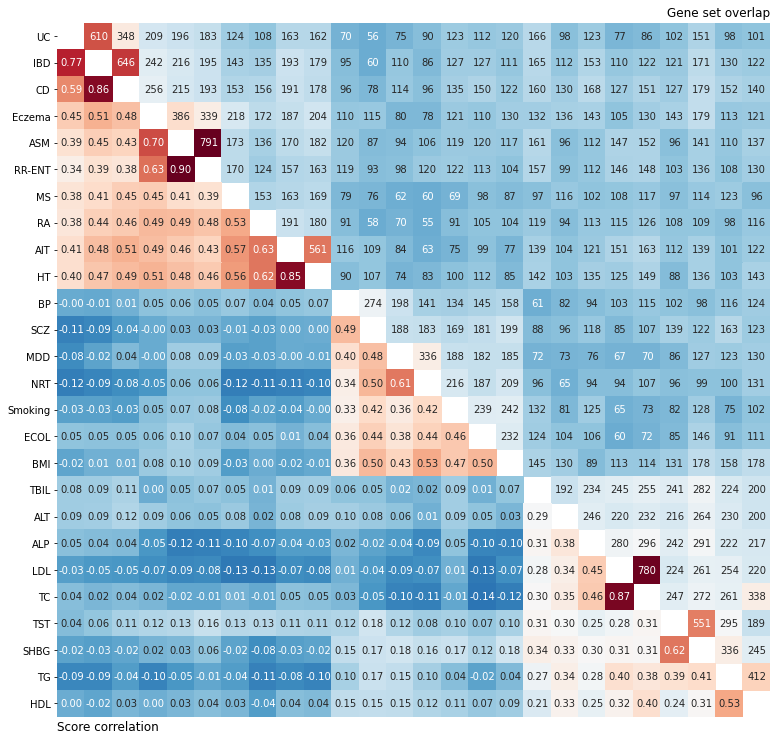

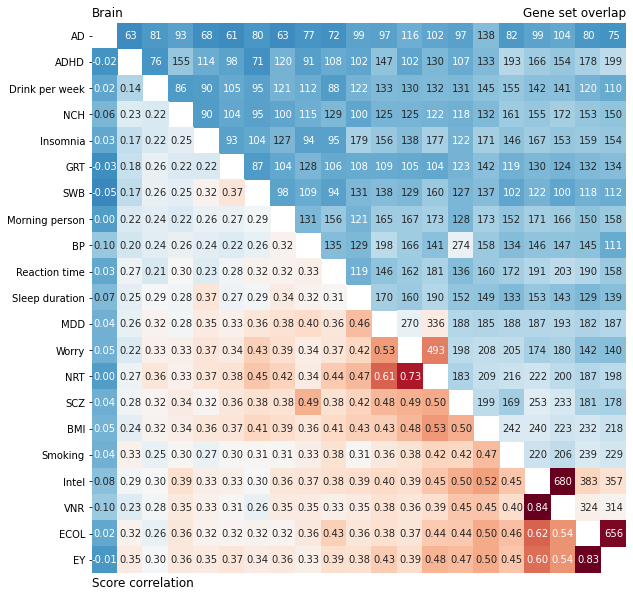

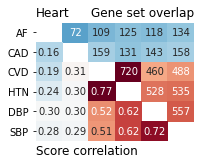

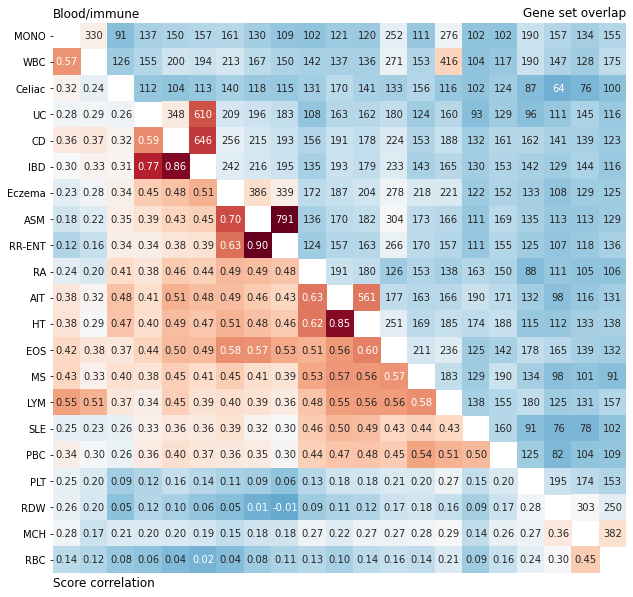

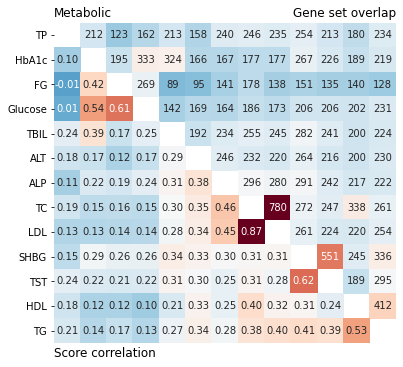

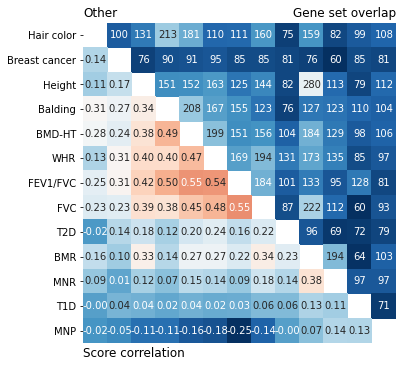

In [6]:
# Heatmap: overlap + correlation
for cate in ['main']+cate_list:
    if cate == 'main':
        trait_list_cate = trait_list_main
    else:
        trait_list_cate = [x for x in trait_list if DF_TRAIT_INFO.loc[x, 'Category']==cate]
    df_overlap_cate = df_overlap.loc[trait_list_cate, trait_list_cate]
    df_corr_cate = df_corr.loc[trait_list_cate, trait_list_cate]
    trait_list_reorder = scdrs.util.reorder_col(df_corr_cate)
    
    df_plot_upper = df_overlap_cate.loc[trait_list_reorder, trait_list_reorder].copy()
    df_plot_upper.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_plot_upper.index]
    mat_mask_upper = np.tril(np.ones_like(df_plot_upper, dtype=np.bool), k=0)
    v_val_overlap = df_plot_upper.values[np.tril_indices(df_plot_upper.shape[0], k=-1)]
    
    df_plot_lower = df_corr_cate.loc[trait_list_reorder, trait_list_reorder].copy()
    df_plot_lower.index = [DF_TRAIT_INFO.loc[x, 'Code'] for x in df_plot_lower.index]
    mat_mask_lower = np.triu(np.ones_like(df_plot_lower, dtype=np.bool), k=0)
    v_val_corr = df_plot_lower.values[np.tril_indices(df_plot_lower.shape[0], k=-1)]

    plt.figure(figsize=[0.5+len(trait_list_cate)*0.4, len(trait_list_cate)*0.4])
    sns.heatmap(df_plot_upper, annot=df_plot_upper, fmt='d', mask=mat_mask_upper,
                xticklabels=False, yticklabels=False, cmap = 'RdBu_r', center=300, cbar=False)
    sns.heatmap(df_plot_lower, annot=df_plot_lower, fmt='.2f', mask=mat_mask_lower,
                xticklabels=False, yticklabels=True, cmap = 'RdBu_r', center=0.3, cbar=False)
    plt.yticks(rotation=0)     
    plt.xlabel('Score correlation', loc='left', fontsize=12)
    plt.title('Gene set overlap', loc='right', fontsize=12)
    if cate != 'main':
        plt.title(cate.capitalize(), loc='left', fontsize=12)
    plt.tight_layout()
    plt.savefig(FIG_PATH+'/score_corr_%s.svg'%cate.replace('/','_'))
    plt.show()
#     break

### Contrast association of different traits

In [7]:
# Contrast the cell populations
ds_raw,ds_proc,score,trait_list = 'tms_facs','tms_facs.tcell','tms_facs',DIC_TRAIT_LIST['immune']
# ds_raw,ds_proc,score,trait_list = 'tms_facs','tms_facs.hep','tms_facs',DIC_TRAIT_LIST['metabolic']

# Get data to work with 
df_corr = dic_score[score][['%s.norm_score'%x for x in trait_list]].corr()
df_corr.columns = [x.replace('.norm_score','') for x in df_corr.columns]
df_corr.index = [x.replace('.norm_score','') for x in df_corr.index]

df_corr_ct = dic_score[score].loc[dic_data_proc[ds_proc].obs_names, ['%s.norm_score'%x for x in trait_list]].corr()
df_corr_ct.columns = [x.replace('.norm_score','') for x in df_corr_ct.columns]
df_corr_ct.index = [x.replace('.norm_score','') for x in df_corr_ct.index]

# Get an independent list of traits using greedy method
trait_list_indpt = ['PASS_IBD_deLange2017']
# trait_list_indpt = ['UKB_460K.biochemistry_Triglycerides']
for trait in DF_TRAIT_INFO.loc[trait_list].sort_values('Z', ascending=False).index:
    if (df_corr.loc[trait_list_indpt, trait]>0.5).sum()==0:
        trait_list_indpt.append(trait)
print('trait_list_indpt', trait_list_indpt)

df_plot = pd.DataFrame(index=dic_data_proc[ds_proc].obs_names,
                       data={'UMAP1':dic_data_proc[ds_proc].obsm['X_umap'][:,0],
                             'UMAP2':dic_data_proc[ds_proc].obsm['X_umap'][:,1]})

cell_list = sorted(set(df_plot.index) & set(dic_score[score].index))
df_plot = df_plot.loc[cell_list].copy()

col_list = []
for x in trait_list:
    col_list += ['%s.norm_score'%x, '%s.pval'%x, '%s.fdr'%x]
df_plot = df_plot.join(dic_score[score][col_list])
# df_plot = df_plot.join(dic_score[score_ref][col_list])

trait_list_indpt ['PASS_IBD_deLange2017', 'UKB_460K.disease_HYPOTHYROIDISM_SELF_REP', 'UKB_460K.disease_RESPIRATORY_ENT']


PASS_IBD_deLange2017 64 UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 776
PASS_IBD_deLange2017 57 UKB_460K.disease_RESPIRATORY_ENT 561
UKB_460K.disease_HYPOTHYROIDISM_SELF_REP 403 UKB_460K.disease_RESPIRATORY_ENT 213


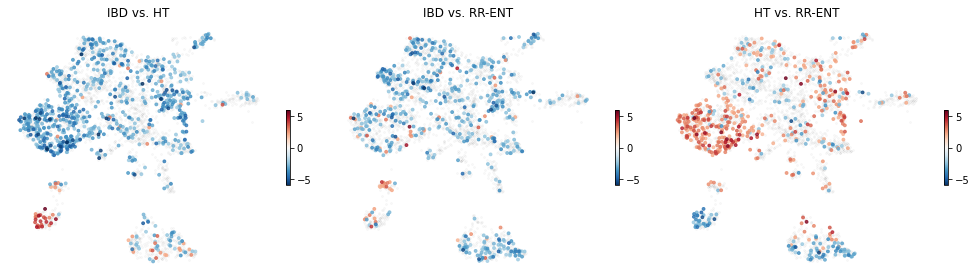

In [8]:
n_plot = int(len(trait_list_indpt) * (len(trait_list_indpt)-1) /2)
n_col = 3
n_row = np.ceil(n_plot/3).astype(int)

plt.figure(figsize=[14,n_row*4])
i_plot = 1
for i in range(len(trait_list_indpt)):
    for j in range(i+1,len(trait_list_indpt)):            
        trait1,trait2 = trait_list_indpt[i],trait_list_indpt[j]
        ax = plt.subplot(n_row, n_col, i_plot)
        i_plot +=1 
        ax.axis('off')
        
        df_plot['%s vs. %s'%(trait1,trait2)] = df_plot['%s.norm_score'%trait1] - df_plot['%s.norm_score'%trait2]
        ind_select1 = (df_plot['%s.fdr'%trait1]<0.1) & (df_plot['%s vs. %s'%(trait1,trait2)]>2)
        ind_select2 = (df_plot['%s.fdr'%trait2]<0.1) & (df_plot['%s vs. %s'%(trait1,trait2)]<-2)
        print(trait1, ind_select1.sum(), trait2, ind_select2.sum())
        ind_select = ind_select1 | ind_select2
        cell_list_plot = df_plot.index[ind_select][
            np.argsort( np.absolute(df_plot.loc[ind_select, '%s vs. %s'%(trait1,trait2)]) )
        ]
        
        plt.scatter(df_plot.loc[~ind_select, 'UMAP1'], df_plot.loc[~ind_select, 'UMAP2'],
                    c='k', s=4, alpha=0.025)
        plt.scatter(df_plot.loc[cell_list_plot, 'UMAP1'], df_plot.loc[cell_list_plot, 'UMAP2'], 
                    c=df_plot.loc[cell_list_plot, '%s vs. %s'%(trait1,trait2)],
                    cmap='RdBu_r', vmin=-6, vmax=6, s=8, alpha=0.8)
        plt.title('%s vs. %s'%(DF_TRAIT_INFO.loc[trait1, 'Code'], DF_TRAIT_INFO.loc[trait2, 'Code']))
        plt.colorbar(shrink=0.3)
        
plt.tight_layout()
# plt.savefig(FIG_PATH+'/cellpop_immune.svg')
plt.show()